In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torch.optim as optim
import pandas as pd
from model.cnn_model import CNNClassifier
from model.lstm_model import LSTMClassifier
from evaluation.eval_func import evaluate_cnn, evaluate_lstm
from dataclasses import dataclass
from utils.func import load_checkpoint
from train.cnn_train_func import Collate
from data.data_loading import CommentLabelDataset, collate
from torch.utils.data import Dataset, DataLoader

Configure device and set batch size

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

load test set

In [3]:
test_data = pd.read_pickle('data/data_file/test_set.pkl')
test_data = test_data.sample(frac=1, random_state=1)
test_set = CommentLabelDataset(test_data)

# Evaluate best CNN model

Create loader for CNN

In [4]:
cnn_colate = Collate(322)
cnn_test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=cnn_colate)

Set parameters

In [5]:
@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = 322
    num_words: int = 39583

    # Model parameters
    embedding_size: int = 64
    out_size: int = 40
    stride: int = 2

    # Training parameters
    epochs: int = 1
    batch_size: int = 30
    learning_rate: float = 0.001

Create model and load checkpoint

In [8]:
best_cnn_model = CNNClassifier(Parameters).to(device)
cnn_optimizer = optim.Adam(best_cnn_model.parameters(), lr=0.001)
load_checkpoint('./train/checkpoints/cnn/model.pt', best_cnn_model, cnn_optimizer)

Model loaded from <== ./train/checkpoints/cnn/model.pt


0.10009751074454364

Run model on test set and print metrics

model running time:  48.629130601882935
Classification Report:
              precision    recall  f1-score   support

           1     0.7263    0.4542    0.5589     21062
           0     0.9669    0.9894    0.9780    339138

    accuracy                         0.9581    360200
   macro avg     0.8466    0.7218    0.7684    360200
weighted avg     0.9528    0.9581    0.9535    360200

roc_auc_score: 0.9167489421401639


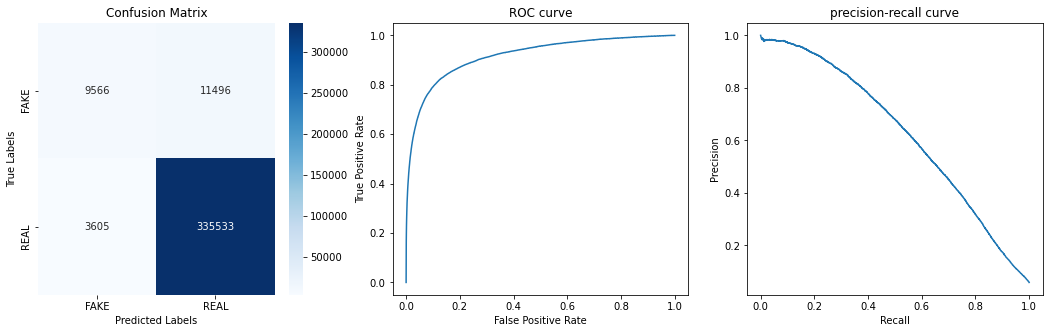

In [9]:
evaluate_cnn(best_cnn_model, cnn_test_loader)

# Evaluate best LSTM model

set parameters

In [12]:
VOCAB_SIZE = 39583
SEED = 0
BATCH_SIZE = 30
EMB_DIM = 64
LSTM_DIM = 10

create loader for LSTM

In [13]:
rnn_test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

create model and load from checkpoint

In [14]:
best_lstm_model = LSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMB_DIM,
    hidden_dim=LSTM_DIM,
    layer=1).to(device)
lstm_optimizer = optim.Adam(best_lstm_model.parameters(), lr=0.001)
load_checkpoint('./train/checkpoints/lstm/model.pt', best_lstm_model, lstm_optimizer)

Model loaded from <== ./train/checkpoints/lstm/model.pt


0.09791394705226754

Run model on test set and print metrics

model running time:  98.85095977783203
Classification Report:
              precision    recall  f1-score   support

           1     0.7580    0.5321    0.6253     21062
           0     0.9715    0.9894    0.9804    339138

    accuracy                         0.9627    360200
   macro avg     0.8647    0.7608    0.8028    360200
weighted avg     0.9590    0.9627    0.9596    360200

roc_auc_score: 0.958590980461701


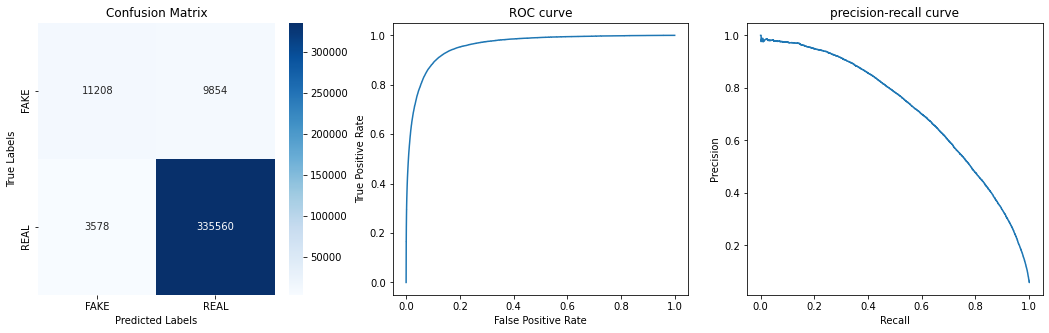

In [15]:
evaluate_lstm(best_lstm_model, rnn_test_loader)